# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import math
import pandas as pd
import seaborn as sns
import datetime
from sklearn import metrics,neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform, randint as sp_randint
#from matplotlib import style

# Read Data

In [2]:
city = ['Delhi','Mumbai','Chennai','Kolkata']
total_city = ['T.Delhi','T.Mumbai','T.Chennai','T.Kolkata']
raw_case_df = (pd.read_excel("Total_Cases_Clean.xlsx")).drop(columns = total_city)
raw_air_df = pd.read_csv("AQI_Data_31Jan2021.csv")
raw_case_df.Date = pd.to_datetime(raw_case_df.Date,dayfirst=True)
raw_air_df.Date = pd.to_datetime(raw_air_df.Date,dayfirst=True)
#Lag factor
_lag_ = 4

# Data Mining

Preprocessing of daily case data

In [3]:
#Dropping rows with NaN values
raw_case_df.dropna(axis=0,inplace=True)
#Setting Date as index
raw_case_df.set_index('Date',inplace=True)
#Checking for negative values
print('Number of rows having negative values in case dataframe : ' ,
      raw_case_df[(raw_case_df['Delhi'] < 0) | (raw_case_df['Mumbai'] < 0) | (raw_case_df['Chennai'] < 0) | (raw_case_df['Kolkata'] < 0) ].shape[0])
#Replacing negative values with 0
raw_case_df[raw_case_df < 0] = 0
#Replacing zero with mean. Only Mumbai city has negative (replaced with 0) values
raw_case_df[raw_case_df == 0] = raw_case_df['Mumbai'].mean()
raw_case_df.head()

Number of rows having negative values in case dataframe :  4


,Delhi,Mumbai,Chennai,Kolkata
Date,,,,
2020-07-07,2008.0,785.0,1213.0,291.0
2020-07-08,2033.0,1347.0,1270.0,366.0
2020-07-09,2187.0,1268.0,1228.0,322.0
2020-07-10,2089.0,1337.0,1241.0,374.0
2020-07-11,1781.0,1284.0,1189.0,412.0


In [4]:
def process_daily_cases (city):
    case_df = raw_case_df[city].to_frame()
    case_df_lag = raw_case_df[city].to_frame()
    case_df_lag.index = case_df_lag.index+pd.to_timedelta(_lag_,unit="d")
    case_df.rename(columns={city: "Daily_Cases"},inplace=True)
    case_df['City'] = city
    return(case_df)

In [5]:
li=[]
for i in city:
    city_df=process_daily_cases(i)
    li.append(city_df)
major_cities_df=pd.concat(li,ignore_index=False,axis=0)

In [6]:
#Dropping rows with NaN 
major_cities_df.dropna(axis=0,inplace=True)
#Unique key generation
major_cities_df['Unique'] = major_cities_df["City"]+"|"+major_cities_df.index.astype('str')
major_cities_df['Daily_Cases'] = major_cities_df['Daily_Cases'].astype(int)

In [7]:
major_cities_df.head()

,Daily_Cases,City,Unique
Date,,,
2020-07-07,2008,Delhi,Delhi|2020-07-07
2020-07-08,2033,Delhi,Delhi|2020-07-08
2020-07-09,2187,Delhi,Delhi|2020-07-09
2020-07-10,2089,Delhi,Delhi|2020-07-10
2020-07-11,1781,Delhi,Delhi|2020-07-11


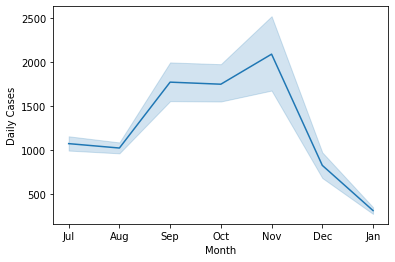

In [8]:
graph_df = major_cities_df.drop(columns=['Unique'])
graph_df['Month'] = major_cities_df.index.strftime("%b")
graph_df.rename(columns={'Daily_Cases': 'Daily Cases'},inplace=True)
sns.lineplot('Month','Daily Cases',data=graph_df, sort=False)

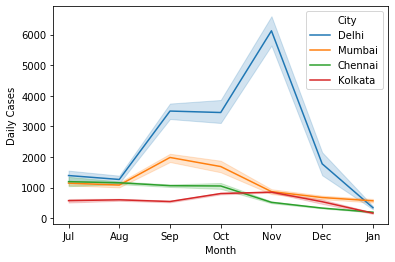

In [9]:
sns.lineplot('Month','Daily Cases', hue='City', data=graph_df, sort=False)

In [10]:
major_cities_df.drop(columns=['City'],inplace=True)
major_cities_df.head(5)

,Daily_Cases,Unique
Date,,
2020-07-07,2008,Delhi|2020-07-07
2020-07-08,2033,Delhi|2020-07-08
2020-07-09,2187,Delhi|2020-07-09
2020-07-10,2089,Delhi|2020-07-10
2020-07-11,1781,Delhi|2020-07-11


Preprocessing of air data

In [11]:
#Dropping State, Station_ID and Station_Name
raw_air_df.drop(columns = ['Unnamed: 0','State','Station_ID','Station_Name'],inplace=True)
#Filtering rows with city
raw_air_df = raw_air_df[raw_air_df['City'].isin(city)]
#creating a unique variable
raw_air_df["Unique"]=raw_air_df["City"]+"|"+raw_air_df["Date"].astype('str')
#sorting based on Date
raw_air_df.sort_values(by="Date",inplace=True)

In [12]:
air_df = raw_air_df.groupby(by=["City","Date"]).count().reset_index()[["City","Date"]]
air_df.Date=air_df.Date+pd.to_timedelta(_lag_,unit="d")
air_df['Unique'] = air_df["City"]+"|"+air_df["Date"].astype('str')
for col in raw_air_df.select_dtypes(include=[np.number]).columns:
    groupby_citydate=raw_air_df.groupby(by=["Unique"])
    if(col.find('maximum')!=-1):
        group_df=pd.DataFrame(groupby_citydate.mean()[col])
        air_df=air_df.join(group_df,on="Unique")
    elif(col.find('minimum')!=-1):
        group_df=pd.DataFrame(groupby_citydate.mean()[col])
        air_df=air_df.join(group_df,on="Unique")
    else:
        group_df=pd.DataFrame(groupby_citydate.mean()[col])
        air_df=air_df.join(group_df,on="Unique")

In [13]:
#Cities having null values for pollution parameters
print('Cities having null values for pollution parameters : ',air_df[air_df.isna().any(axis=1)].City.unique()[0])
print('Number of rows having null values : ',air_df[air_df.isna().any(axis=1)].shape[0])
#Columns having null values in Dataframe
j=0
na_col = []
for i in air_df.isna().any():
    if(i):
        na_col.append(air_df.isna().any().index[j])
    j = j + 1
print('Columns with null values(air_df):',na_col)

#replacing nan with respective mean
for i in air_df[air_df.isna().any(axis=1)].index:
    for j in na_col:
        if  math.isnan(air_df.loc[i,j]):
            air_df.loc[i,j] = air_df[air_df.City == 'Chennai'][j].mean()

Cities having null values for pollution parameters :  Chennai
Number of rows having null values :  38
Columns with null values(air_df): ['PM2.5_average', 'PM2.5_minimum', 'PM2.5_maximum', 'PM10_average', 'PM10_minimum', 'PM10_maximum', 'NO2_average', 'NO2_minimum', 'NO2_maximum', 'SO2_average', 'SO2_minimum', 'SO2_maximum', 'CO_average', 'CO_minimum', 'CO_maximum', 'OZONE_average', 'OZONE_minimum', 'OZONE_maximum', 'NH3_average', 'NH3_minimum', 'NH3_maximum']


In [14]:
major_cities_df = air_df.join(major_cities_df.set_index('Unique'),on='Unique')
major_cities_df.head()

,City,Date,Unique,PM2.5_average,PM2.5_minimum,PM2.5_maximum,PM10_average,PM10_minimum,PM10_maximum,NO2_average,...,CO_average,CO_minimum,CO_maximum,OZONE_average,OZONE_minimum,OZONE_maximum,NH3_average,NH3_minimum,NH3_maximum,Daily_Cases
0,Chennai,2020-07-05,Chennai|2020-07-05,16.666667,3.333333,51.333333,26.0,4.0,72.0,12.333333,...,35.000000,24.666667,44.333333,65.000000,20.666667,115.333333,8.0,7.0,9.0,NaN
1,Chennai,2020-07-06,Chennai|2020-07-06,23.500000,6.500000,52.000000,39.0,15.0,100.0,10.666667,...,32.000000,25.666667,43.666667,39.333333,21.333333,80.000000,7.0,7.0,8.0,NaN
2,Chennai,2020-07-07,Chennai|2020-07-07,34.250000,9.750000,65.000000,60.0,22.0,118.0,21.500000,...,52.250000,45.000000,67.750000,59.000000,21.333333,101.333333,10.0,8.0,24.0,1213.0
3,Chennai,2020-07-08,Chennai|2020-07-08,23.666667,9.000000,44.000000,74.0,19.0,135.0,15.666667,...,37.333333,26.000000,46.333333,58.333333,30.000000,100.000000,7.0,6.0,8.0,1270.0
4,Chennai,2020-07-09,Chennai|2020-07-09,34.750000,14.000000,83.500000,60.0,24.0,115.0,18.000000,...,46.250000,22.250000,66.750000,59.000000,26.666667,102.666667,11.0,9.0,14.0,1228.0


In [15]:
major_cities_df.dropna(axis=0,inplace=True)

In [16]:
major_cities_df.sort_values(axis=0,by = 'Date').head(4).drop(columns=
                                                             ['Unique',
                                                             'PM2.5_average','PM2.5_minimum',
                                                             'PM10_average','PM10_minimum',
                                                             'NO2_average','NO2_minimum',
                                                             'SO2_average','SO2_minimum',
                                                             'CO_average','CO_minimum',
                                                             'OZONE_average','OZONE_minimum',
                                                             'NH3_average','NH3_minimum'])

,City,Date,PM2.5_maximum,PM10_maximum,NO2_maximum,SO2_maximum,CO_maximum,OZONE_maximum,NH3_maximum,Daily_Cases
2,Chennai,2020-07-07,65.000000,118.000000,46.750000,14.500000,67.750000,101.333333,24.000000,1213.0
186,Delhi,2020-07-07,163.428571,135.791667,47.214286,26.636364,76.656250,55.806452,10.333333,2008.0
554,Mumbai,2020-07-07,29.400000,81.428571,12.142857,24.833333,19.714286,15.142857,6.600000,785.0
370,Kolkata,2020-07-07,26.000000,29.800000,36.500000,15.285714,25.142857,43.428571,3.833333,291.0


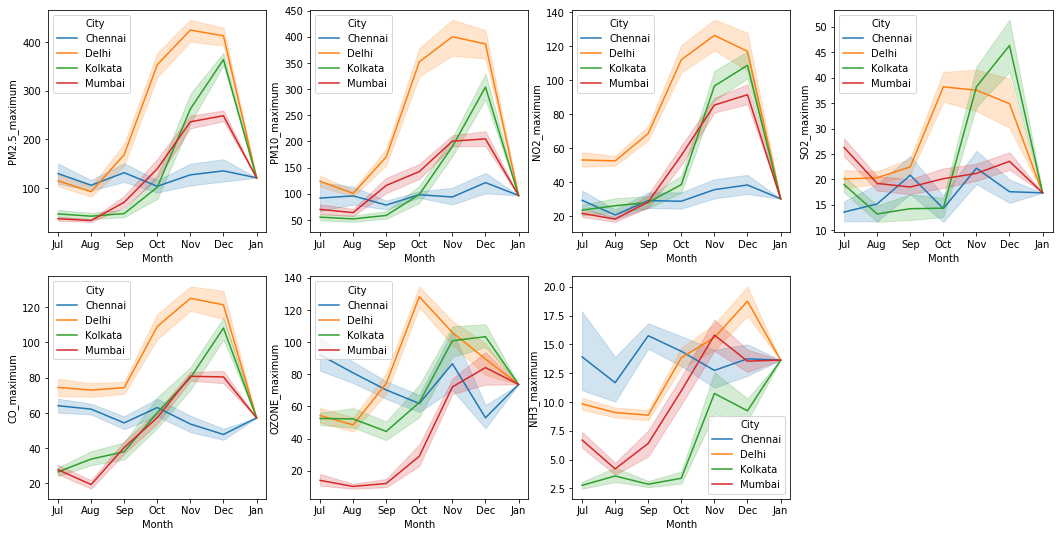

In [17]:
pollutant_cols = ['PM2.5_maximum','PM10_maximum','NO2_maximum','SO2_maximum','CO_maximum','OZONE_maximum','NH3_maximum']
air_graph_df = major_cities_df.drop(columns=['Unique','Daily_Cases'])
air_graph_df['Date'] = air_graph_df['Date'].apply(lambda x: x.strftime('%b'))
air_graph_df.rename(columns={'Date': 'Month'},inplace=True)
plt.figure(figsize=(18,9))
j=1
for k in pollutant_cols:
    plt.subplot(2,4,j)
    sns.lineplot('Month',k,data=air_graph_df,hue='City', sort=False)
    j = j + 1

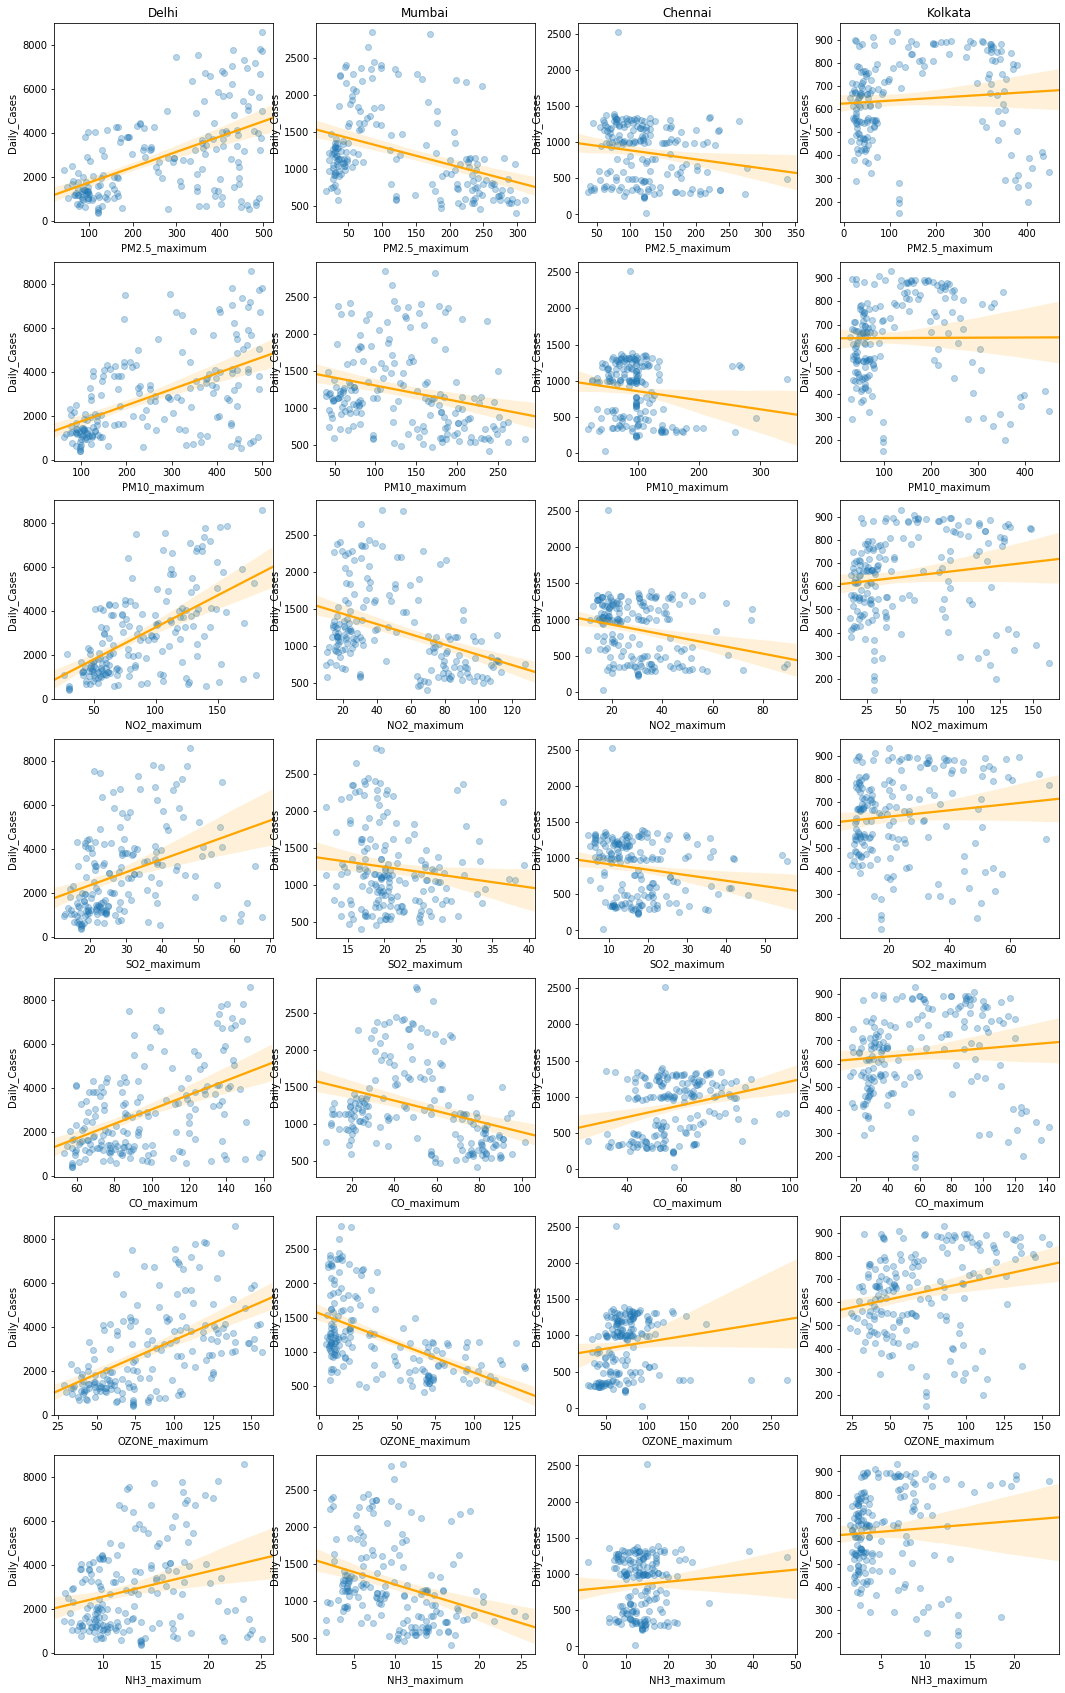

In [18]:
plt.figure(figsize=(18,30))
j=1
for k in pollutant_cols:
    for i in city:
        plt.subplot(7,4,j)
        sns.regplot(x=k, y='Daily_Cases', data=major_cities_df[major_cities_df['City'] == i],scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
        if(j <= 4):
            plt.title(i)
        j = j + 1

In [19]:
corr_df=pd.DataFrame(major_cities_df.corr())
corr_df

,PM2.5_average,PM2.5_minimum,PM2.5_maximum,PM10_average,PM10_minimum,PM10_maximum,NO2_average,NO2_minimum,NO2_maximum,SO2_average,...,CO_average,CO_minimum,CO_maximum,OZONE_average,OZONE_minimum,OZONE_maximum,NH3_average,NH3_minimum,NH3_maximum,Daily_Cases
PM2.5_average,1.000000,0.934500,0.965037,0.968092,0.938063,0.942531,0.923148,0.920500,0.882818,0.548329,...,0.870263,0.671593,0.861529,0.268915,-0.260813,0.624978,0.499338,0.410518,0.480916,0.474470
PM2.5_minimum,0.934500,1.000000,0.849474,0.898196,0.919739,0.839005,0.833193,0.876920,0.784517,0.508784,...,0.794340,0.665225,0.761409,0.214377,-0.229177,0.543736,0.418621,0.349575,0.398235,0.368140
PM2.5_maximum,0.965037,0.849474,1.000000,0.931196,0.891330,0.935082,0.906617,0.882869,0.882667,0.510388,...,0.863857,0.664559,0.878228,0.327107,-0.241160,0.660772,0.559411,0.464875,0.538191,0.464210
PM10_average,0.968092,0.898196,0.931196,1.000000,0.955413,0.970685,0.925359,0.900423,0.892360,0.566186,...,0.864214,0.676305,0.851560,0.245448,-0.305082,0.591482,0.493705,0.408106,0.466758,0.558130
PM10_minimum,0.938063,0.919739,0.891330,0.955413,1.000000,0.901018,0.901382,0.901693,0.865632,0.570658,...,0.793388,0.656088,0.781780,0.233831,-0.336627,0.549798,0.397001,0.315465,0.386244,0.462386
PM10_maximum,0.942531,0.839005,0.935082,0.970685,0.901018,1.000000,0.908967,0.866979,0.884539,0.558611,...,0.864835,0.654035,0.863293,0.242386,-0.313221,0.586304,0.516674,0.431580,0.485554,0.551300
NO2_average,0.923148,0.833193,0.906617,0.925359,0.901382,0.908967,1.000000,0.959290,0.978829,0.587859,...,0.872869,0.611543,0.876346,0.260019,-0.335708,0.626992,0.417453,0.303902,0.448966,0.499598
NO2_minimum,0.920500,0.876920,0.882869,0.900423,0.901693,0.866979,0.959290,1.000000,0.911428,0.555388,...,0.847555,0.606424,0.841137,0.245518,-0.282806,0.596924,0.374607,0.289473,0.387648,0.459214
NO2_maximum,0.882818,0.784517,0.882667,0.892360,0.865632,0.884539,0.978829,0.911428,1.000000,0.560102,...,0.857942,0.605303,0.868853,0.269961,-0.344166,0.614708,0.436885,0.310718,0.477967,0.471178
SO2_average,0.548329,0.508784,0.510388,0.566186,0.570658,0.558611,0.587859,0.555388,0.560102,1.000000,...,0.389424,0.172473,0.383364,-0.148983,-0.505808,0.157558,0.118836,0.037012,0.147593,0.333828


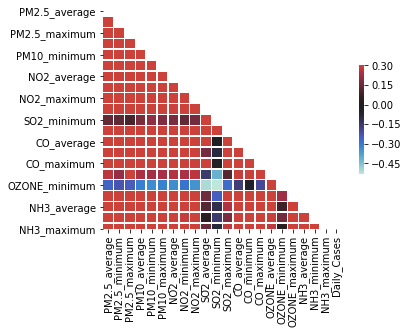

In [20]:
df_print = corr_df['Daily_Cases'].to_frame()
df_print.rename(columns = {'Daily_Cases':'Daily Cases'},inplace=True)
mask = np.triu(np.ones_like(corr_df, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_df, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Train Test Split

In [21]:
x = major_cities_df.drop(columns = ['City','Date','Unique','Daily_Cases'])
y = major_cities_df['Daily_Cases']

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [23]:
x_train.shape

(509, 21)

# Logistic Regression

In [24]:
results = []

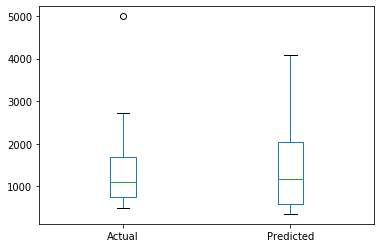

In [25]:
model_log = LogisticRegression()
model_log.fit(x_train,y_train)
y_pred = model_log.predict(x_test)
result_log = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
results.append(['Logistic Regression',metrics.mean_absolute_error(y_test, y_pred),
                metrics.mean_absolute_error(y, model_log.predict(x))])
major_cities_df["y_log"]=model_log.predict(x)
result_log.head(20).plot(kind = 'box')

# KNN

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


141.36813186813185

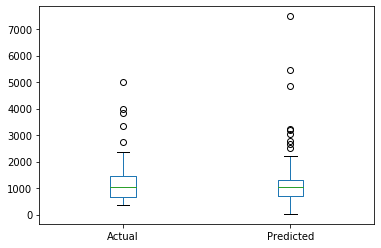

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.fit_transform(x_test)
x_scaled       = scaler.fit_transform(x)
params = {'n_neighbors':range(1,100)}
knn = neighbors.KNeighborsRegressor()
model_best_param = GridSearchCV(knn, params, cv=5)
model_best_param.fit(x_train_scaled,y_train)

model_knn = neighbors.KNeighborsRegressor(n_neighbors = (model_best_param.best_params_)['n_neighbors'])
model_knn.fit(x_train_scaled, y_train)
y_pred = model_knn.predict(x_test_scaled)
result_knn = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
results.append(['KNN',metrics.mean_absolute_error(y_test, y_pred),metrics.mean_absolute_error(y, model_knn.predict(x_scaled))])
major_cities_df["y_knn"]=model_knn.predict(x_scaled)
result_knn.head(50).plot(kind = 'box')
metrics.mean_absolute_error(y, model_knn.predict(x_scaled))

# LGBM

In [27]:
lgb_model = LGBMRegressor(subsample=0.9)

params = {'learning_rate': uniform(0, 1),
          'n_estimators': sp_randint(200, 1500),
          'num_leaves': sp_randint(20, 200),
          'max_depth': sp_randint(2, 15),
          'min_child_weight': uniform(0, 2),
          'colsample_bytree': uniform(0, 1),
         }
lgb_random = RandomizedSearchCV(lgb_model, param_distributions=params, n_iter=10, cv=3, random_state=50, 
                                 verbose=10, return_train_score=True)
lgb_random = lgb_random.fit(x_train, y_train)
best_params = lgb_random.best_params_
print(best_params)
model_lgbm = LGBMRegressor(**best_params,subsample=0.9, random_state=42, n_jobs=-1)
model_lgbm.fit(x_train, y_train)
y_pred = model_lgbm.predict(x_test)
major_cities_df["y_lgbm"]=model_lgbm.predict(x)
results.append(['LGBM',metrics.mean_absolute_error(y_test, y_pred),metrics.mean_absolute_error(y, major_cities_df["y_lgbm"])])
result_lgbm = pd.DataFrame({'Actual':y,'Predicted':major_cities_df["y_lgbm"]})

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] colsample_bytree=0.49460164553802144, learning_rate=0.22808310444933622, max_depth=3, min_child_weight=1.2198762654711293, n_estimators=270, num_leaves=90 
[CV]  colsample_bytree=0.49460164553802144, learning_rate=0.22808310444933622, max_depth=3, min_child_weight=1.2198762654711293, n_estimators=270, num_leaves=90, score=(train=0.990, test=0.600), total=   0.1s
[CV] colsample_bytree=0.49460164553802144, learning_rate=0.22808310444933622, max_depth=3, min_child_weight=1.2198762654711293, n_estimators=270, num_leaves=90 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  colsample_bytree=0.49460164553802144, learning_rate=0.22808310444933622, max_depth=3, min_child_weight=1.2198762654711293, n_estimators=270, num_leaves=90, score=(train=0.989, test=0.636), total=   0.1s
[CV] colsample_bytree=0.49460164553802144, learning_rate=0.22808310444933622, max_depth=3, min_child_weight=1.2198762654711293, n_estimators=270, num_leaves=90 
[CV]  colsample_bytree=0.49460164553802144, learning_rate=0.22808310444933622, max_depth=3, min_child_weight=1.2198762654711293, n_estimators=270, num_leaves=90, score=(train=0.990, test=0.559), total=   0.1s
[CV] colsample_bytree=0.9965742301546493, learning_rate=0.40819720033319706, max_depth=12, min_child_weight=1.5210733760177686, n_estimators=1174, num_leaves=183 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


[CV]  colsample_bytree=0.9965742301546493, learning_rate=0.40819720033319706, max_depth=12, min_child_weight=1.5210733760177686, n_estimators=1174, num_leaves=183, score=(train=1.000, test=0.627), total=   0.8s
[CV] colsample_bytree=0.9965742301546493, learning_rate=0.40819720033319706, max_depth=12, min_child_weight=1.5210733760177686, n_estimators=1174, num_leaves=183 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s


[CV]  colsample_bytree=0.9965742301546493, learning_rate=0.40819720033319706, max_depth=12, min_child_weight=1.5210733760177686, n_estimators=1174, num_leaves=183, score=(train=0.999, test=0.558), total=   1.1s
[CV] colsample_bytree=0.9965742301546493, learning_rate=0.40819720033319706, max_depth=12, min_child_weight=1.5210733760177686, n_estimators=1174, num_leaves=183 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s


[CV]  colsample_bytree=0.9965742301546493, learning_rate=0.40819720033319706, max_depth=12, min_child_weight=1.5210733760177686, n_estimators=1174, num_leaves=183, score=(train=0.999, test=0.446), total=   0.8s
[CV] colsample_bytree=0.13478847110096226, learning_rate=0.5947232555260275, max_depth=8, min_child_weight=1.9453293694349005, n_estimators=999, num_leaves=69 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.0s remaining:    0.0s


[CV]  colsample_bytree=0.13478847110096226, learning_rate=0.5947232555260275, max_depth=8, min_child_weight=1.9453293694349005, n_estimators=999, num_leaves=69, score=(train=1.000, test=0.517), total=   0.5s
[CV] colsample_bytree=0.13478847110096226, learning_rate=0.5947232555260275, max_depth=8, min_child_weight=1.9453293694349005, n_estimators=999, num_leaves=69 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.5s remaining:    0.0s


[CV]  colsample_bytree=0.13478847110096226, learning_rate=0.5947232555260275, max_depth=8, min_child_weight=1.9453293694349005, n_estimators=999, num_leaves=69, score=(train=0.999, test=0.504), total=   0.5s
[CV] colsample_bytree=0.13478847110096226, learning_rate=0.5947232555260275, max_depth=8, min_child_weight=1.9453293694349005, n_estimators=999, num_leaves=69 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.0s remaining:    0.0s


[CV]  colsample_bytree=0.13478847110096226, learning_rate=0.5947232555260275, max_depth=8, min_child_weight=1.9453293694349005, n_estimators=999, num_leaves=69, score=(train=0.999, test=0.477), total=   0.7s
[CV] colsample_bytree=0.559957103722125, learning_rate=0.3135907464967046, max_depth=13, min_child_weight=1.349146131644528, n_estimators=279, num_leaves=178 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.7s remaining:    0.0s


[CV]  colsample_bytree=0.559957103722125, learning_rate=0.3135907464967046, max_depth=13, min_child_weight=1.349146131644528, n_estimators=279, num_leaves=178, score=(train=1.000, test=0.601), total=   0.2s
[CV] colsample_bytree=0.559957103722125, learning_rate=0.3135907464967046, max_depth=13, min_child_weight=1.349146131644528, n_estimators=279, num_leaves=178 
[CV]  colsample_bytree=0.559957103722125, learning_rate=0.3135907464967046, max_depth=13, min_child_weight=1.349146131644528, n_estimators=279, num_leaves=178, score=(train=0.999, test=0.617), total=   0.2s
[CV] colsample_bytree=0.559957103722125, learning_rate=0.3135907464967046, max_depth=13, min_child_weight=1.349146131644528, n_estimators=279, num_leaves=178 
[CV]  colsample_bytree=0.559957103722125, learning_rate=0.3135907464967046, max_depth=13, min_child_weight=1.349146131644528, n_estimators=279, num_leaves=178, score=(train=0.999, test=0.511), total=   0.2s
[CV] colsample_bytree=0.7892701888390146, learning_rate=0.364

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.8s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


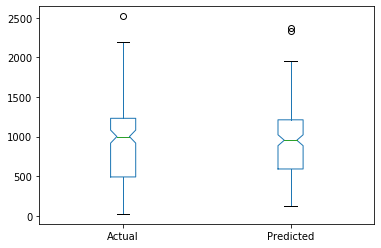

In [28]:
result_lgbm.head(200).plot(kind = 'box',notch='True')

In [29]:
result_lgbm.head(200).describe()

,Actual,Predicted
count,200.000000,200.000000
mean,920.025000,937.259497
std,439.128333,409.064906
min,23.000000,121.329405
25%,489.750000,590.244113
50%,999.000000,952.921850
75%,1229.750000,1210.694620
max,2518.000000,2374.532276


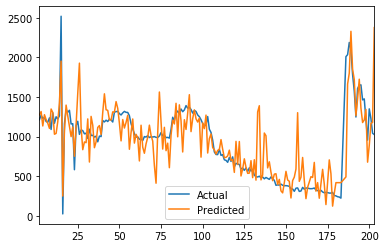

In [30]:
result_lgbm.head(200).plot(kind='line')

# Ensemble

In [31]:
df = major_cities_df.drop(columns = ['Unique','City','Date'])
df['Daily Cases'] = df['Daily_Cases']
df.drop(columns = ['Daily_Cases'],inplace=True)

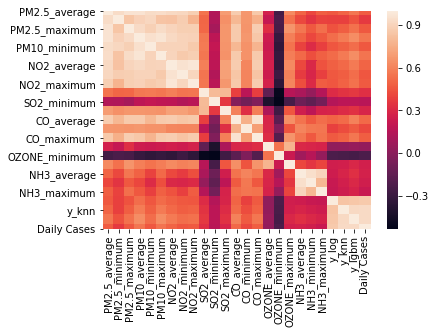

In [32]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df.corr())

In [33]:
col_to_drop = []
for i in df.columns:
    if (i != 'Daily Cases'):
        _corr_ = df[i].corr(df['Daily Cases'])
        print('Correlation between Daily Cases and', i ,': ',_corr_)
        if (_corr_ < 0.25):
            col_to_drop.append(i)
col_to_drop

Correlation between Daily Cases and PM2.5_average :  0.47446980392219723
Correlation between Daily Cases and PM2.5_minimum :  0.3681401775180806
Correlation between Daily Cases and PM2.5_maximum :  0.46421005817560207
Correlation between Daily Cases and PM10_average :  0.5581301968491171
Correlation between Daily Cases and PM10_minimum :  0.4623861503815603
Correlation between Daily Cases and PM10_maximum :  0.5513001120725236
Correlation between Daily Cases and NO2_average :  0.49959785657773853
Correlation between Daily Cases and NO2_minimum :  0.45921395311030905
Correlation between Daily Cases and NO2_maximum :  0.47117832760351863
Correlation between Daily Cases and SO2_average :  0.33382791945527873
Correlation between Daily Cases and SO2_minimum :  0.1652271129019293
Correlation between Daily Cases and SO2_maximum :  0.292782440085678
Correlation between Daily Cases and CO_average :  0.5180543941716933
Correlation between Daily Cases and CO_minimum :  0.4163404830912859
Correlat

['SO2_minimum', 'OZONE_average', 'OZONE_minimum', 'NH3_maximum']

In [34]:
df.drop(columns = col_to_drop,inplace=True)

In [35]:
df.corr()

,PM2.5_average,PM2.5_minimum,PM2.5_maximum,PM10_average,PM10_minimum,PM10_maximum,NO2_average,NO2_minimum,NO2_maximum,SO2_average,...,CO_average,CO_minimum,CO_maximum,OZONE_maximum,NH3_average,NH3_minimum,y_log,y_knn,y_lgbm,Daily Cases
PM2.5_average,1.000000,0.934500,0.965037,0.968092,0.938063,0.942531,0.923148,0.920500,0.882818,0.548329,...,0.870263,0.671593,0.861529,0.624978,0.499338,0.410518,0.461922,0.498808,0.558241,0.474470
PM2.5_minimum,0.934500,1.000000,0.849474,0.898196,0.919739,0.839005,0.833193,0.876920,0.784517,0.508784,...,0.794340,0.665225,0.761409,0.543736,0.418621,0.349575,0.392431,0.392393,0.444557,0.368140
PM2.5_maximum,0.965037,0.849474,1.000000,0.931196,0.891330,0.935082,0.906617,0.882869,0.882667,0.510388,...,0.863857,0.664559,0.878228,0.660772,0.559411,0.464875,0.443861,0.484924,0.542140,0.464210
PM10_average,0.968092,0.898196,0.931196,1.000000,0.955413,0.970685,0.925359,0.900423,0.892360,0.566186,...,0.864214,0.676305,0.851560,0.591482,0.493705,0.408106,0.530830,0.577199,0.639938,0.558130
PM10_minimum,0.938063,0.919739,0.891330,0.955413,1.000000,0.901018,0.901382,0.901693,0.865632,0.570658,...,0.793388,0.656088,0.781780,0.549798,0.397001,0.315465,0.459776,0.486838,0.531809,0.462386
PM10_maximum,0.942531,0.839005,0.935082,0.970685,0.901018,1.000000,0.908967,0.866979,0.884539,0.558611,...,0.864835,0.654035,0.863293,0.586304,0.516674,0.431580,0.526746,0.575085,0.637318,0.551300
NO2_average,0.923148,0.833193,0.906617,0.925359,0.901382,0.908967,1.000000,0.959290,0.978829,0.587859,...,0.872869,0.611543,0.876346,0.626992,0.417453,0.303902,0.490014,0.517055,0.571010,0.499598
NO2_minimum,0.920500,0.876920,0.882869,0.900423,0.901693,0.866979,0.959290,1.000000,0.911428,0.555388,...,0.847555,0.606424,0.841137,0.596924,0.374607,0.289473,0.463071,0.481939,0.531627,0.459214
NO2_maximum,0.882818,0.784517,0.882667,0.892360,0.865632,0.884539,0.978829,0.911428,1.000000,0.560102,...,0.857942,0.605303,0.868853,0.614708,0.436885,0.310718,0.460187,0.492706,0.545003,0.471178
SO2_average,0.548329,0.508784,0.510388,0.566186,0.570658,0.558611,0.587859,0.555388,0.560102,1.000000,...,0.389424,0.172473,0.383364,0.157558,0.118836,0.037012,0.313819,0.345788,0.364603,0.333828


In [36]:
X = df.drop(columns = ['Daily Cases'])
Y = df['Daily Cases']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

model = LGBMRegressor(subsample=0.9)

params = {'learning_rate': uniform(0, 1),
          'n_estimators': sp_randint(200, 1500),
          'num_leaves': sp_randint(20, 200),
          'max_depth': sp_randint(2, 15),
          'min_child_weight': uniform(0, 2),
          'colsample_bytree': uniform(0, 1),
         }
model = RandomizedSearchCV(model, param_distributions=params, n_iter=10, cv=3, random_state=50, 
                                 verbose=10, return_train_score=True)
model_random = model.fit(X_train, Y_train)
best_params = model_random.best_params_
model_e = LGBMRegressor(**best_params,subsample=0.9, random_state=42, n_jobs=-1)
model_e.fit(X_train, Y_train)
Y_pred = model_e.predict(X_test)
results.append(['LGBM E',metrics.mean_absolute_error(Y_test, Y_pred),metrics.mean_absolute_error(Y, model_e.predict(X))])
result_lgbm_e = pd.DataFrame({'Actual':y,'Predicted':model_e.predict(X)})

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] colsample_bytree=0.49460164553802144, learning_rate=0.22808310444933622, max_depth=3, min_child_weight=1.2198762654711293, n_estimators=270, num_leaves=90 
[CV]  colsample_bytree=0.49460164553802144, learning_rate=0.22808310444933622, max_depth=3, min_child_weight=1.2198762654711293, n_estimators=270, num_leaves=90, score=(train=0.994, test=0.811), total=   0.1s
[CV] colsample_bytree=0.49460164553802144, learning_rate=0.22808310444933622, max_depth=3, min_child_weight=1.2198762654711293, n_estimators=270, num_leaves=90 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  colsample_bytree=0.49460164553802144, learning_rate=0.22808310444933622, max_depth=3, min_child_weight=1.2198762654711293, n_estimators=270, num_leaves=90, score=(train=0.996, test=0.888), total=   0.1s
[CV] colsample_bytree=0.49460164553802144, learning_rate=0.22808310444933622, max_depth=3, min_child_weight=1.2198762654711293, n_estimators=270, num_leaves=90 
[CV]  colsample_bytree=0.49460164553802144, learning_rate=0.22808310444933622, max_depth=3, min_child_weight=1.2198762654711293, n_estimators=270, num_leaves=90, score=(train=0.991, test=0.873), total=   0.1s
[CV] colsample_bytree=0.9965742301546493, learning_rate=0.40819720033319706, max_depth=12, min_child_weight=1.5210733760177686, n_estimators=1174, num_leaves=183 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


[CV]  colsample_bytree=0.9965742301546493, learning_rate=0.40819720033319706, max_depth=12, min_child_weight=1.5210733760177686, n_estimators=1174, num_leaves=183, score=(train=0.999, test=0.807), total=   1.1s
[CV] colsample_bytree=0.9965742301546493, learning_rate=0.40819720033319706, max_depth=12, min_child_weight=1.5210733760177686, n_estimators=1174, num_leaves=183 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s


[CV]  colsample_bytree=0.9965742301546493, learning_rate=0.40819720033319706, max_depth=12, min_child_weight=1.5210733760177686, n_estimators=1174, num_leaves=183, score=(train=1.000, test=0.881), total=   0.9s
[CV] colsample_bytree=0.9965742301546493, learning_rate=0.40819720033319706, max_depth=12, min_child_weight=1.5210733760177686, n_estimators=1174, num_leaves=183 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s remaining:    0.0s


[CV]  colsample_bytree=0.9965742301546493, learning_rate=0.40819720033319706, max_depth=12, min_child_weight=1.5210733760177686, n_estimators=1174, num_leaves=183, score=(train=0.999, test=0.873), total=   0.9s
[CV] colsample_bytree=0.13478847110096226, learning_rate=0.5947232555260275, max_depth=8, min_child_weight=1.9453293694349005, n_estimators=999, num_leaves=69 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.2s remaining:    0.0s


[CV]  colsample_bytree=0.13478847110096226, learning_rate=0.5947232555260275, max_depth=8, min_child_weight=1.9453293694349005, n_estimators=999, num_leaves=69, score=(train=0.999, test=0.650), total=   0.6s
[CV] colsample_bytree=0.13478847110096226, learning_rate=0.5947232555260275, max_depth=8, min_child_weight=1.9453293694349005, n_estimators=999, num_leaves=69 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.9s remaining:    0.0s


[CV]  colsample_bytree=0.13478847110096226, learning_rate=0.5947232555260275, max_depth=8, min_child_weight=1.9453293694349005, n_estimators=999, num_leaves=69, score=(train=1.000, test=0.657), total=   0.5s
[CV] colsample_bytree=0.13478847110096226, learning_rate=0.5947232555260275, max_depth=8, min_child_weight=1.9453293694349005, n_estimators=999, num_leaves=69 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.5s remaining:    0.0s


[CV]  colsample_bytree=0.13478847110096226, learning_rate=0.5947232555260275, max_depth=8, min_child_weight=1.9453293694349005, n_estimators=999, num_leaves=69, score=(train=0.999, test=0.739), total=   0.5s
[CV] colsample_bytree=0.559957103722125, learning_rate=0.3135907464967046, max_depth=13, min_child_weight=1.349146131644528, n_estimators=279, num_leaves=178 
[CV]  colsample_bytree=0.559957103722125, learning_rate=0.3135907464967046, max_depth=13, min_child_weight=1.349146131644528, n_estimators=279, num_leaves=178, score=(train=0.998, test=0.790), total=   0.2s

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.9s remaining:    0.0s



[CV] colsample_bytree=0.559957103722125, learning_rate=0.3135907464967046, max_depth=13, min_child_weight=1.349146131644528, n_estimators=279, num_leaves=178 
[CV]  colsample_bytree=0.559957103722125, learning_rate=0.3135907464967046, max_depth=13, min_child_weight=1.349146131644528, n_estimators=279, num_leaves=178, score=(train=1.000, test=0.874), total=   0.2s
[CV] colsample_bytree=0.559957103722125, learning_rate=0.3135907464967046, max_depth=13, min_child_weight=1.349146131644528, n_estimators=279, num_leaves=178 
[CV]  colsample_bytree=0.559957103722125, learning_rate=0.3135907464967046, max_depth=13, min_child_weight=1.349146131644528, n_estimators=279, num_leaves=178, score=(train=0.998, test=0.873), total=   0.2s
[CV] colsample_bytree=0.7892701888390146, learning_rate=0.3644193405509064, max_depth=14, min_child_weight=1.1427461380778532, n_estimators=1172, num_leaves=87 
[CV]  colsample_bytree=0.7892701888390146, learning_rate=0.3644193405509064, max_depth=14, min_child_weigh

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.4s finished


# Results

In [37]:
results_df = pd.DataFrame(results,columns = ['Method', 'MAE(Test)','MAE'])
results_df

,Method,MAE(Test),MAE
0,Logistic Regression,662.858447,202.300824
1,KNN,661.378995,141.368132
2,LGBM,558.995785,249.975653
3,LGBM E,208.005618,65.523287


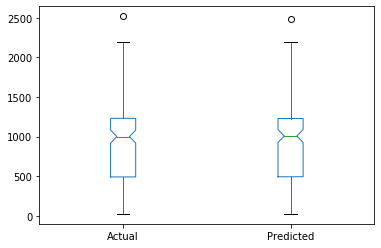

In [43]:
result_lgbm_e.head(200).plot(kind = 'box',notch='True')

In [47]:
result_lgbm_e.head(200).describe()

,Actual,Predicted
count,200.000000,200.000000
mean,920.025000,922.947975
std,439.128333,437.085607
min,23.000000,22.999818
25%,489.750000,492.000901
50%,999.000000,1005.999588
75%,1229.750000,1227.249885
max,2518.000000,2480.393467


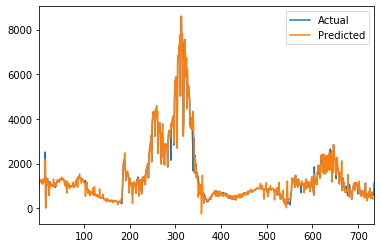

In [39]:
result_lgbm_e.plot(kind='line')

In [42]:
result_lgbm_e[abs(result_lgbm_e['Actual'] - result_lgbm_e['Predicted']) < 10].shape[0]

513

In [44]:
result_lgbm_e.shape

(728, 2)

In [46]:
result_lgbm_e.head(6)

,Actual,Predicted
2,1213.0,1058.892920
3,1270.0,1269.999972
4,1228.0,1227.999544
5,1241.0,1275.959799
6,1189.0,1189.000207
7,1180.0,1179.999931
